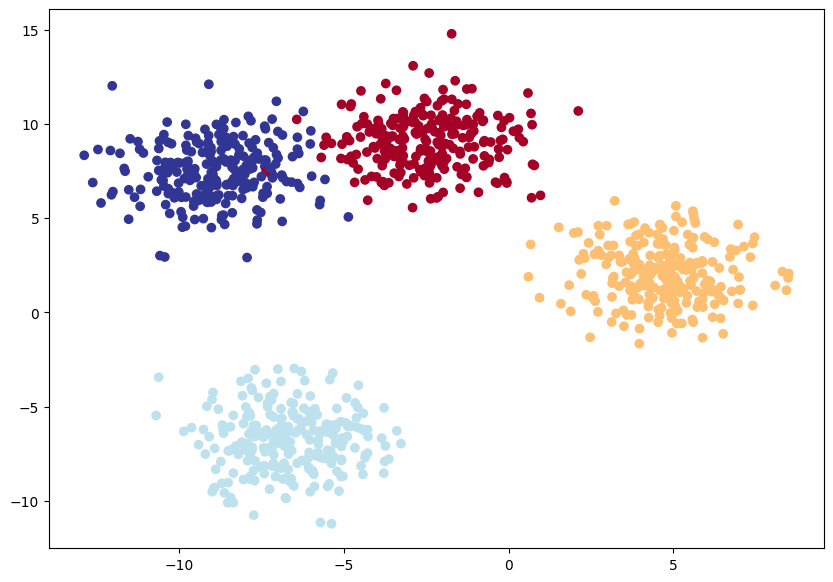

In [13]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)
X_blob = torch.from_numpy(X_blob)
y_blob = torch.from_numpy(y_blob)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

X_blob_train = X_blob_train.type(torch.float32)
X_blob_test = X_blob_test.type(torch.float32)

plt.figure(figsize = (10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu)

In [14]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [15]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

multi_class_model = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device) 
multi_class_model  

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=multi_class_model.parameters(), lr=0.1)

In [17]:
y_logits = multi_class_model(X_blob_test.to(device))
y_pred_probs = torch.softmax(y_logits, dim = 1)

In [18]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/ len(y_pred))*100
    return acc

In [23]:
torch.manual_seed(42)

epochs = 100

X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    multi_class_model.train()

    y_logits = multi_class_model(X_blob_train)
    y_pred_probs = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy(y_true=y_blob_train, y_pred=y_pred_probs)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    multi_class_model.eval()

    with torch.inference_mode():
        test_logits = multi_class_model(X_blob_test)
        test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy(y_true=y_blob_test, y_pred=test_preds)
    
    if epoch%10 == 0:
        print(f"EPOCH : [{epoch}/{epochs}] | TRAIN ACCURACY : {acc : .8f} | TRAIN LOSS : {loss} | TEST ACCURACY : {test_acc} | TEST LOSS : {test_loss}")

EPOCH : [0/100] | TRAIN ACCURACY :  99.50000000 | TRAIN LOSS : 0.014003473334014416 | TEST ACCURACY : 100.0 | TEST LOSS : 0.0023574018850922585
EPOCH : [10/100] | TRAIN ACCURACY :  99.37500000 | TRAIN LOSS : 0.01393479947000742 | TEST ACCURACY : 100.0 | TEST LOSS : 0.002614642959088087
EPOCH : [20/100] | TRAIN ACCURACY :  99.37500000 | TRAIN LOSS : 0.014081399887800217 | TEST ACCURACY : 100.0 | TEST LOSS : 0.00215220358222723
EPOCH : [30/100] | TRAIN ACCURACY :  99.37500000 | TRAIN LOSS : 0.01386803388595581 | TEST ACCURACY : 100.0 | TEST LOSS : 0.0022143139503896236
EPOCH : [40/100] | TRAIN ACCURACY :  99.50000000 | TRAIN LOSS : 0.013908527791500092 | TEST ACCURACY : 100.0 | TEST LOSS : 0.0026787607930600643
EPOCH : [50/100] | TRAIN ACCURACY :  99.37500000 | TRAIN LOSS : 0.014000024646520615 | TEST ACCURACY : 100.0 | TEST LOSS : 0.0022281347773969173
EPOCH : [60/100] | TRAIN ACCURACY :  99.50000000 | TRAIN LOSS : 0.013928014785051346 | TEST ACCURACY : 100.0 | TEST LOSS : 0.00236416119

In [28]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of a model predicting on X in comparison to y."""
    # Put everything to CPU for NumPy and Matplotlib
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # 1. Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # 2. Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # 3. Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # 4. Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # multi-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # 5. Reshape predictions and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

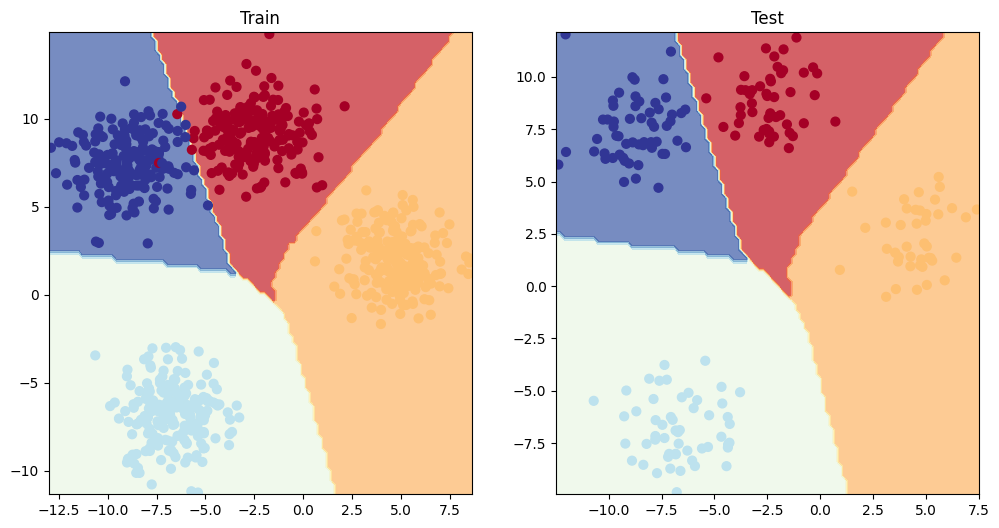

In [29]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(multi_class_model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(multi_class_model, X_blob_test, y_blob_test)